<a href="https://colab.research.google.com/github/RajratanWankhade/CNN-for-Computer-Vision-Problem/blob/main/Deep_Learning_Classification_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plots
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import io
import os
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy, BinaryCrossentropy, RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers  import L2, L1
from tensorboard.plugins.hparams import api as hp
#

In [ ]:
dataset, dataset_info = tfds.load('malaria', with_info=True,
                                  as_supervised=True,
                                  shuffle_files = True,
                                  split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [ ]:
for data in dataset[0].take(1):
  print(data)

NameError: name 'd' is not defined

In [ ]:

def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [ ]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO )
#print(list(train_dataset.take(1).as_numpy_iterator()),
 #     list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator()))

**DATA Visulization**

In [ ]:

for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i + 1)

  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis("off")

**Data Preprocessing**

In [ ]:
IM_SIZE = 224
def resizing(image, label):
  image = tf.image.resize(image, (IM_SIZE, IM_SIZE))
  return image, label

In [ ]:
#train_dataset = train_dataset.map(resizing)

In [ ]:
for image, label in train_dataset.take(1):
  print(image.shape)

In [ ]:
print(image, label)

In [ ]:
IM_SIZE = 224
def resize_rescale(image, label):
  image = tf.image.resize(image, (IM_SIZE, IM_SIZE))
  image = image/255.0
  return image, label

In [ ]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)
train_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
for image, label in train_dataset.take(1):
  print(image, label)

In [ ]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
BATCH_SIZE = 32
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import InputLayer, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError

#IM_SIZE = 64  # Define the image size

# Define the model
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),
    tf.keras.layers.Conv2D(filters=6, kernel_size=5, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

    tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

    Flatten(),

    Dense(1000, activation='relu'),
    BatchNormalization(),

    Dense(100, activation='relu'),
    BatchNormalization(),

    Dense(1, activation='sigmoid')  # Single output unit for binary classification
])



# Display the model summary
lenet_model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 220, 220, 6)       456       
                                                                 
 batch_normalization (Batch  (None, 220, 220, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 6)       0         
 D)                                                              
                                                                 
 conv2d_4 (Conv2D)           (None, 106, 106, 16)      2416      
                                                                 
 batch_normalization_1 (Bat  (None, 106, 106, 16)      64        
 chNormalization)                                                
                                                        

In [ ]:
# Compile the model
lenet_model.compile(optimizer=Adam(learning_rate=0.001),
              loss=BinaryCrossentropy(from_logits=False),
              metrics=[RootMeanSquaredError()])



history = lenet_model.fit(train_dataset,  epochs=1, verbose=1)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import InputLayer, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError

#IM_SIZE = 64  # Define the image size

# Define the model
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),
    tf.keras.layers.Conv2D(filters=6, kernel_size=5, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

    tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

    Flatten(),

    Dense(1000, activation='relu'),
    BatchNormalization(),

    Dense(100, activation='relu'),
    BatchNormalization(),

    Dense(1, activation='sigmoid')  # Single output unit for binary classification
])



# Display the model summary
lenet_model.summary()




Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 220, 220, 6)       456       
                                                                 
 batch_normalization_4 (Bat  (None, 220, 220, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 110, 110, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 106, 106, 16)      2416      
                                                                 
 batch_normalization_5 (Bat  (None, 106, 106, 16)      64        
 chNormalization)                                                
                                                      

In [ ]:
# Compile the model
lenet_model.compile(optimizer=Adam(learning_rate=0.001),
              loss=BinaryCrossentropy(from_logits=False),
              metrics='accuracy')



#
history = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs=10, verbose=1)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

NameError: name 'history' is not defined

In [ ]:
test_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
test_dataset = test_dataset.batch(1)
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
lenet_model.evaluate(test_dataset)

2757/2757 [==============================] - 23s 4ms/step - loss: 0.5110 - accuracy: 0.9394


[0.5109629034996033, 0.9394268989562988]

In [ ]:
lenet_model.predict(test_dataset.take(1))[0][0]

1/1 [==============================] - 11s 11s/step


'Not Parasite'

In [ ]:
def parasite_or_not(x):
  if x < 0.5:
    return 'Parasite'
  else:
    return 'Not Parasite'


In [ ]:
parasite_or_not(lenet_model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 13s 13s/step


'Not Parasite'

1/1 [==============================] - 0s 20ms/step


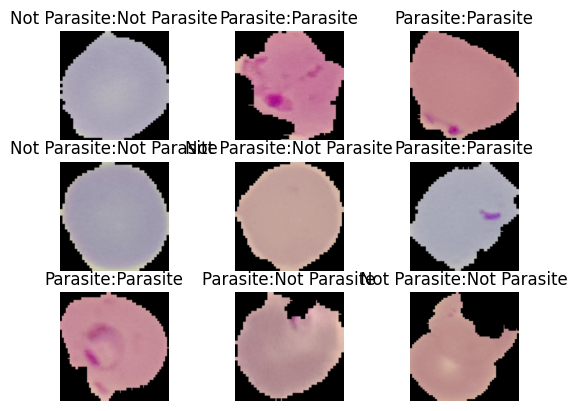

In [ ]:
for i, (image, label) in enumerate(test_dataset.take(9)):

  ax = plt.subplot(3, 3, i + 1)

  plt.imshow(image[0])
  plt.title(parasite_or_not(label.numpy()[0]) + ":" + parasite_or_not(lenet_model.predict(image)[0][0]))
  plt.axis("off")

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


cp: cannot stat '/content/lenet/': No such file or directory


##Functional API##

In [ ]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name = "Input Image")

In [ ]:


x = tf.keras.layers.Conv2D(filters=6, kernel_size=5, strides=1, padding='valid', activation='relu')(func_input)
x = BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)(x)

x =  tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=1, padding='valid', activation='relu')(x)
x =  BatchNormalization()(x)
x =  tf.keras.layers.MaxPool2D(pool_size=2, strides=2)(x)

x =  Flatten()(x)

x =  Dense(1000, activation='relu')(x)
x = BatchNormalization()(x)

x =  Dense(100, activation='relu')(x)
x =  BatchNormalization()(x)

func_output =  Dense(1, activation='sigmoid') (x)

lenet_model_func = Model(func_input, func_output, name = "Lenet_Model")

lenet_model_func.summary()


Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 220, 220, 6)       456       
                                                                 
 batch_normalization_8 (Bat  (None, 220, 220, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 110, 110, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 106, 106, 16)      2416      
                                                                 
 batch_normalization_9 (Bat  (None, 106, 106, 16)      

In [ ]:
lenet_model_func.compile(optimizer=Adam(learning_rate=0.001),
              loss=BinaryCrossentropy(from_logits=False),
              metrics='accuracy')

In [ ]:
history = lenet_model_func.fit(train_dataset, validation_data=val_dataset, epochs=5, verbose=1)

Epoch 1/5
689/689 [==============================] - 65s 83ms/step - loss: 0.3828 - accuracy: 0.8329 - val_loss: 0.2777 - val_accuracy: 0.8944
Epoch 2/5
689/689 [==============================] - 48s 69ms/step - loss: 0.2255 - accuracy: 0.9195 - val_loss: 0.2409 - val_accuracy: 0.9183
Epoch 3/5
689/689 [==============================] - 48s 70ms/step - loss: 0.1805 - accuracy: 0.9352 - val_loss: 0.1913 - val_accuracy: 0.9354
Epoch 4/5
689/689 [==============================] - 48s 69ms/step - loss: 0.1462 - accuracy: 0.9457 - val_loss: 0.1724 - val_accuracy: 0.9405
Epoch 5/5
689/689 [==============================] - 47s 69ms/step - loss: 0.1131 - accuracy: 0.9580 - val_loss: 0.1961 - val_accuracy: 0.9452


In [ ]:
x = tf.keras.layers.Conv2D(filters=6, kernel_size=5, strides=1, padding='valid', activation='relu')(func_input)
x = BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)(x)

x =  tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=1, padding='valid', activation='relu')(x)
x =  BatchNormalization()(x)
output =  tf.keras.layers.MaxPool2D(pool_size=2, strides=2)(x)



feature_extractor_model = Model(func_input, func_output, name = "Feature_Extractor")

feature_extractor_model.summary()


Model: "Feature_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Feature_Extractor (Functio  (None, 1)                 45052561  
 nal)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 1)                 0         
                                                                 
 dense_12 (Dense)            (None, 1000)              2000      
                                                                 
 batch_normalization_16 (Ba  (None, 1000)              4000      
 tchNormalization)                                               
                                                                 
 dense_13 (Dense)            (None, 100)         

In [ ]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = feature_extractor_model(func_input)

x =  Flatten()(x)

x =  Dense(1000, activation='relu')(x)
x = BatchNormalization()(x)

x =  Dense(100, activation='relu')(x)
x =  BatchNormalization()(x)

func_output =  Dense(1, activation='sigmoid') (x)

lenet_model_func = Model(func_input, func_output, name = "Lenet_Model")

lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Feature_Extractor (Functio  (None, 1)                 45159162  
 nal)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 1)                 0         
                                                                 
 dense_18 (Dense)            (None, 1000)              2000      
                                                                 
 batch_normalization_22 (Ba  (None, 1000)              4000      
 tchNormalization)                                               
                                                                 
 dense_19 (Dense)            (None, 100)               